In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
sys.path.append("./src")

In [2]:
import spacy
import pickle
import torch
import matplotlib.pyplot as plt

from data.tokenizer import Tokenizer
from data.collate import *
from data.snli.dataset import *
from helpers import hightlight_txt

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [3]:
spacy_model = spacy.load('en_core_web_md')
tokenizer = Tokenizer(spacy_model=spacy_model)
labels = ['neutral', 'entailment']
cache_path = 'src/_out'
data_path='/Users/dunguyen/Dataset/snli'
nb_data = 20

In [4]:
def visualize(lemma1, lemma2, attention1, attention2, pred, y_true):
    html = '<table>'
    html += '<tr> <th>Document 1</th> <th>Document 2</th><th>Prediction</th><th>Label</th> </tr>'
    for i in range(attention1.size(0)):
        html += '<tr> <td>' +  hightlight_txt(lemma1[i], attention1[i]) + '</td><td>' + hightlight_txt(lemma2[i], attention2[i]) +'</td><td>' + str(pred[i].item()) +'</td><td>' + str(y_true[i].item()) +'</td></tr>'
    html += '</table>'
    return html

### Test Torch-NLI model

In [5]:
vocab = SNLIDataset.load_vocab(cache_path=cache_path)
testset = SNLIDataset(data_path=data_path, split='test', nb_data_max=nb_data, tokenizer=tokenizer, cache_path=cache_path, vocab=vocab)

collate_fn = PaddingCollate(multiclass=True, padding_idx=vocab['<pad>'])
test_iterator = DataLoader(testset, collate_fn=collate_fn, batch_size=nb_data, shuffle=False)

tokens1 = [tokenizer(d) for d in testset.data['sentence1']]
tokens2 = [tokenizer(d) for d in testset.data['sentence2']]

Load cache SNLI test: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s, path=src/_out/dataset/snli/snli_test.csv]


In [6]:
from model.pytorch_nli.bilstm_attention import AttentionBiLSTM

model_path = '/Users/dunguyen/Projects/IGRIDA/tmp/models/BiLSTM.attention/best_model.pt'

model = AttentionBiLSTM(d_hidden=300, vocab=vocab, dp_ratio=0.2)
model = torch.load(model_path, map_location=torch.device('cpu'))

# Evaluation mode
model.eval()
with torch.no_grad():
    for x1, x2, y_true in test_iterator:
        y_hat, (a1v2, a2v1) = model(x1, x2)
        y_hat = torch.argmax(y_hat, dim=1)
        a2v1 = a2v1.squeeze(dim=1)
        a1v2 = a1v2.squeeze(dim=1)

In [7]:
text = visualize(tokens1, tokens2, a1v2, a2v1, y_hat, y_true)
display(HTML(text))

Plot attention values

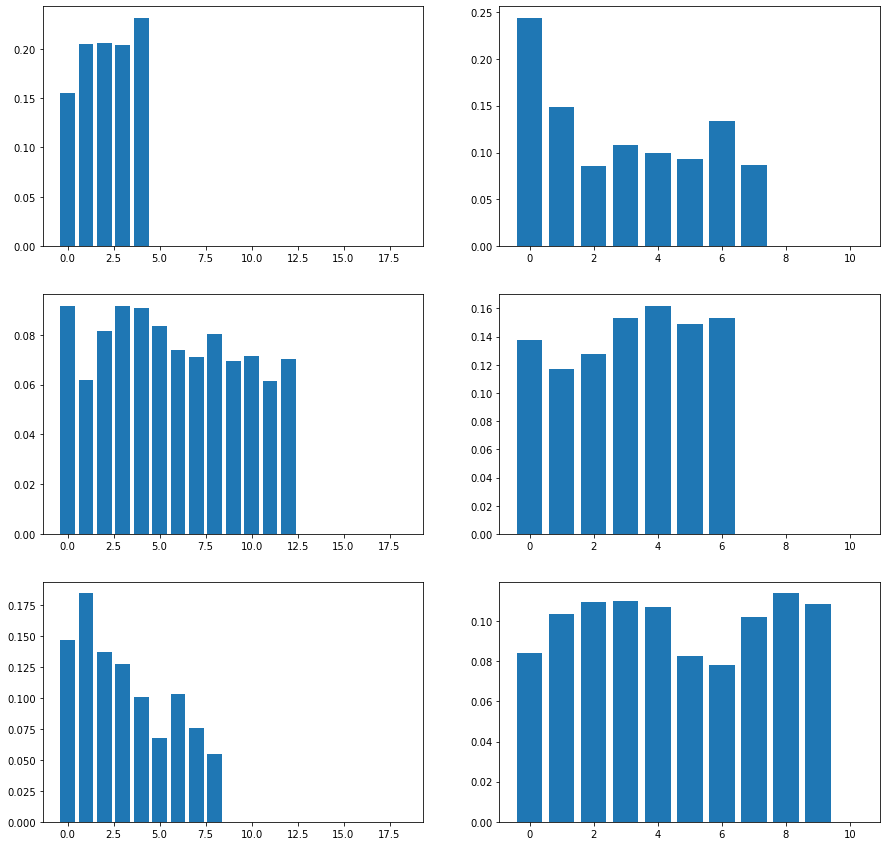

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

for i in range(3):
    ax[i][0].bar(range(a1v2[i].size(0)), a1v2[i].numpy())
    ax[i][1].bar(range(a2v1[i].size(0)), a2v1[i].numpy())

### Meta model using LSTM bidirection

In [9]:
testset = VectorizeSNLIDataset(data_path=data_path, split='test', nb_data_max=nb_data, tokenizer=tokenizer, cache_path=cache_path, vocab=vocab)
collate_fn = VectorizingCollate(multiclass=True, padding_value=0)
test_iterator = DataLoader(testset, collate_fn=collate_fn, batch_size=nb_data, shuffle=False)

tokens1 = [tokenizer(d) for d in testset.data['sentence1']]
tokens2 = [tokenizer(d) for d in testset.data['sentence2']]

Load cache SNLI test: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s, path=src/_out/dataset/snli/snli_test.csv]


In [10]:
from model.multiclass_metamodel import MulticlassMetaModel

model_path = '/Users/dunguyen/Projects/IGRIDA/tmp/models/MulticlassMetaCoreModel.bidirectional/best_model.pt'

model = MulticlassMetaModel(d_hidden=300, vocab=vocab, dp_ratio=0.2)
model = torch.load(model_path, map_location=torch.device('cpu'))

# Evaluation mode
model.eval()
with torch.no_grad():
    for x1, x2, y_true in test_iterator:        
        y_hat, (a1v2, a2v1) = model(x1, x2)
        y_hat = torch.argmax(y_hat, dim=1)
        a2v1 = a2v1.squeeze(dim=1)
        a1v2 = a1v2.squeeze(dim=1)

In [11]:
# TODO: inversed role a2 and a1
text = visualize(tokens1, tokens2, a2v1, a1v2, y_hat, y_true)
display(HTML(text))

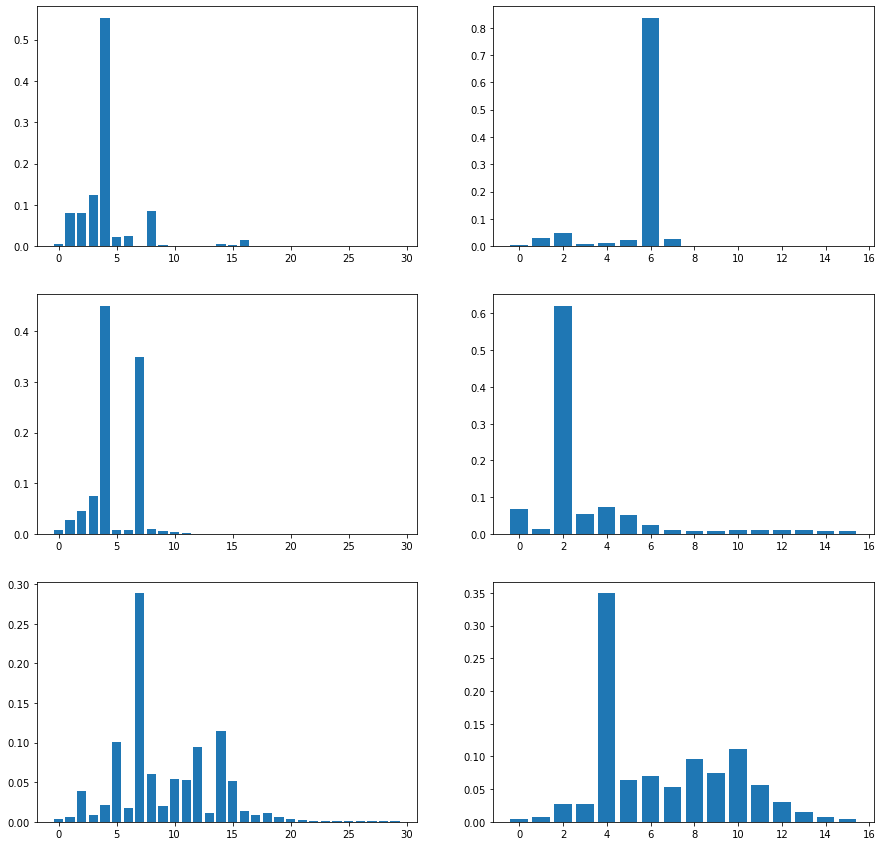

In [12]:
    fig, ax = plt.subplots(3, 2, figsize=(15,15))

    for i in range(3):
        ax[i][0].bar(range(a2v1[i].size(0)), a2v1[i].numpy())
        ax[i][1].bar(range(a1v2[i].size(0)), a1v2[i].numpy())

# Evaluate Softmax

In [13]:
from src.model.multiclass_luong_attention_net import MulticlassLuongAttentionNet

### Load model

In [14]:
dim_hidden = 300
checkpoint_path = 'src/_out/models/ckpt.MultiLuongAttentionNet.snli.multi=2.pt'

model = MulticlassLuongAttentionNet(vocab, d_hidden=300, method='general')
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluation mode
model.eval()

MulticlassLuongAttentionNet(
  (embedding): Embedding(28340, 300, padding_idx=1)
  (lstm): LSTM(300, 300, batch_first=True)
  (attn1v2): LuongAttention(
    (attn_score): LuongGeneralScore()
  )
  (attn2v1): LuongAttention(
    (attn_score): LuongGeneralScore()
  )
  (bilinear): Bilinear(in1_features=300, in2_features=300, out_features=1, bias=True)
  (fc): Linear(in_features=600, out_features=300, bias=True)
  (fc1): Linear(in_features=600, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

### Predict and Inference

In [21]:
preds, (a1v2, a2v1) = model(x1_pad, x2_pad)
preds = preds.detach()
preds = torch.argmax(preds, dim=1)
a1v2 = a1v2.detach()
a2v1 = a2v1.detach()

a2v1 = a2v1.squeeze(dim=1)
a1v2 = a1v2.squeeze(dim=1)

In [12]:
text = visualize(tokens1, tokens2, a1v2, a2v1, y_hat, y_true)
display(HTML(text))

IndexError: index 13 is out of bounds for dimension 0 with size 13

# Evaluate full model for 3 class

In [24]:
dim_hidden = 300
checkpoint_path = 'src/_out/models/ckpt.MultiLuongAttentionNet.snli.multi=3.pt'

model = MulticlassLuongAttentionNet(vocab, d_hidden=300, method='general', n_class=3)
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluation mode
model.eval()

MulticlassLuongAttentionNet(
  (embedding): Embedding(28340, 300, padding_idx=1)
  (lstm): LSTM(300, 300, batch_first=True)
  (attn1v2): LuongAttention(
    (attn_score): LuongGeneralScore()
  )
  (attn2v1): LuongAttention(
    (attn_score): LuongGeneralScore()
  )
  (bilinear): Bilinear(in1_features=300, in2_features=300, out_features=1, bias=True)
  (fc): Linear(in_features=600, out_features=300, bias=True)
  (fc1): Linear(in_features=600, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

### Prepare data for 3 class

In [25]:
with open('src/_out/labels/snli_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
val_labels = load_sub_labels('/Uses/dunguyen/Dataset/snli', 'test', 'src/_out')

val_labels = val_labels[:20]

Load cache SNLI test: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, path=src/_out/labels/snli_test.csv]


In [26]:
# Get prediction results
preds, (a1v2, a2v1) = model(x1_pad, x2_pad)
preds = preds.detach()
preds = torch.argmax(preds, dim=1)
a1v2 = a1v2.detach()
a2v1 = a2v1.detach()

a2v1 = a2v1.squeeze(dim=1)
a1v2 = a1v2.squeeze(dim=1)

In [31]:
def visualize(lemma1, lemma2, attention1, attention2, pred, y_true):
    html = '<table>'
    html += '<tr> <th>Document 1</th> <th>Document 2</th><th>Prediction</th><th>Label</th> </tr>'
    for i in range(attention1.size(0)):
        html += '<tr> <td>' +  hightlight_txt(lemma1[i], attention1[i]) + '</td><td>' + hightlight_txt(lemma2[i], attention2[i]) +'</td><td>' + str(pred[i].item()) +'</td><td>' + str(y_true[i].item()) +'</td></tr>'
    html += '</table>'
    return html

text = visualize(lemma1, lemma2, a2v1, a1v2, preds, y_true)
display(HTML(text))